# Description

Here we introduce a Network for solving pressure poisson 

The network is a Convolutional Neural Network with 5 layers. at some point it splits in three branches because of two subsequent pooling (max)

Each convolutional layer has a filter size of 3x3

In [1]:
import keras as keras
from keras import layers, models
import tensorflow as tf
import numpy as np

2025-06-23 16:26:27.658124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 16:26:28.121127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750688788.274666   96817 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750688788.319934   96817 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750688788.728289   96817 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Loss function

In [2]:
# Laplacian filter
L = tf.constant(
    [[0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]], dtype=tf.float32)
L = tf.reshape(L, [3,3,1,1])

# Definition of the LOSS
def f_obj(rho, W):
    @keras.saving.register_keras_serializable()
    def loss(div_u, p_t):
        # laplacian of pressure
        lap_p = tf.nn.convolution(p_t, L, padding="SAME")

        # Computing objective
        diff = tf.math.squared_difference(div_u, 1/rho * lap_p)
        # obj = tf.math.reduce_sum(tf.math.multiply(W, diff))
        obj = tf.math.reduce_sum(diff)
        return obj
    return loss


custom_loss = f_obj(1,1)

I0000 00:00:1750688800.010217   96817 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


# Network structure

In [3]:
def make_model(input_shape):
    # Define input 
    inputs = keras.Input(shape=(input_shape))
    x = layers.Conv2D(8, 3, activation='relu', padding='same') (inputs)
    x_1 = layers.AveragePooling2D(2) (x)
    x_2 = layers.AveragePooling2D(2) (x_1)

    x = layers.Conv2D(8, 3, activation='relu', padding='same') (x)
    x_1 = layers.Conv2D(8, 3, activation='relu', padding='same') (x_1)
    x_2 = layers.Conv2D(8, 3, activation='relu', padding='same') (x_2)

    # Upscaling of the pooled layers
    x_1 = layers.Resizing(input_shape[0], input_shape[1]) (x_1)
    x_2 = layers.Resizing(input_shape[0], input_shape[1]) (x_2)

    # Sum resized layers
    x = layers.Add() ([x_1, x_2, x])

    # Last convolution
    x = layers.Conv2D(8, 1, activation='relu', padding='same') (x)

    outputs = layers.Conv2D(1, 1, activation=None, padding='same') (x)
    return keras.Model(inputs=inputs, outputs=outputs, name='MyModel')

# NOTE: for now the network is trained with no obstacle whatsover
model = make_model((128,128,1))
model.summary()

model.compile(optimizer='adam',
              loss=custom_loss,
              )

# keras.utils.plot_model(model, "Pressure_CNN.png")

Model: "MyModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │         80 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 64, 64, 8) │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 32, 32, 8) │          0 │ average_pooling2… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64, 8) │        584 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32, 8) │        584 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (Resizing)          │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        584 │ conv2d[0][0]      │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ resizing[0][0],   │
│                     │ 8)                │            │ resizing_1[0][0], │
│                     │                   │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │         72 │ add[0][0]         │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │          9 │ conv2d_4[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,913 (7.47 KB)

 Trainable params: 1,913 (7.47 KB)

 Non-trainable params: 0 (0.00 B)

# Import the dataset

In [4]:
# Load the dataset and do basic stuff as reshaping the input tensor so that they match the keras expected (batch, height, length, n_channels) dimensionality

import os

ds_path = "saved_data/"
path = (os.path.join(os.getcwd(), ds_path) )

try:
    dataset = tf.data.Dataset.load(ds_path)
    dataset_size = dataset.cardinality().numpy()

    print(dataset_size)

    def preprocess(image, label):
        image = tf.expand_dims(input=image, axis=0)
        label = tf.expand_dims(input=label, axis=0)
        return image, label
    
    # Reshape tensor
    dataset = dataset.map(preprocess)

    ds_train = dataset.take(0.8*dataset_size)
    ds_test = dataset.skip(0.8*dataset_size)

    print(ds_test.cardinality())
    print(ds_train.cardinality())

    for (a,b) in ds_test.take(1):
        print(a.shape, b.shape)

except Exception as e:
    print("Dataset could not be loaded:\n\t", e)

Dataset could not be loaded:
	 tf.data snapshot element_spec file not found: saved_data/dataset_spec.pb.


In [5]:
# Improved version
import os
import shutil
from myPackageUtils.dataset_utils import load_dataset

dataset_folder = "saved_data"
path = (os.path.join(os.getcwd(), dataset_folder))
dataset = load_dataset(path)

dataset_size = dataset.cardinality().numpy()

print(dataset_size)

def preprocess(image, label):
    image = tf.expand_dims(input=image, axis=0)
    label = tf.expand_dims(input=label, axis=0)
    return image, label

# Reshape tensor
dataset = dataset.map(preprocess)

ds_train = dataset.take(0.8*dataset_size)
ds_test = dataset.skip(0.8*dataset_size)

print(ds_test.cardinality())
print(ds_train.cardinality())

for (a,b) in ds_test.take(1):
    print(a.shape, b.shape)

Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset9
Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset5
Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset3
Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset8
Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset4
Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset2
Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset0
Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset1
Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset7
Loading dataset from:  /home/peppe/documents/programs/Exercises/saved_data/dataset6
10000
tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(8000, shape=(), dtype=int64)
(1, 128, 128, 1) (1, 128, 128, 1)


2025-06-23 16:26:52.516371: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Train the model and save it

In [11]:
model.fit(ds_train, validation_data=ds_test, epochs=50)

Epoch 1/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - loss: 5.2221 - val_loss: 5.1267
Epoch 2/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 5.2102 - val_loss: 5.1379
Epoch 3/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 5.2049 - val_loss: 5.0861
Epoch 4/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 5.1984 - val_loss: 5.0870
Epoch 5/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 5.1903 - val_loss: 5.1050
Epoch 6/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - loss: 5.1809 - val_loss: 5.0667
Epoch 7/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - loss: 5.1813 - val_loss: 5.0560
Epoch 8/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - loss: 5.1794 - val_loss: 5.1669
Epoch 9/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - loss: 5.1590 - val_loss: 5.0660
Epoch 10/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - loss: 5.1556 - val_loss: 5.0784
Epoch 11/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - loss: 5.1638 - val_loss: 5.0949
Epoch 12/50
8000/80

In [14]:
# Eventually save
save_flag = True

if save_flag:
    path_model = "4_pressure_solution_NET/SAVED_MODEL.keras"
    model.save(path_model)

# Simulate of a feedforward on trained network

tf.Tensor(0.22373983, shape=(), dtype=float32)


/tmp/ipykernel_96817/989686379.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  t1 = spatial_filter(random_noise1, char_len=15).astype(np.double)


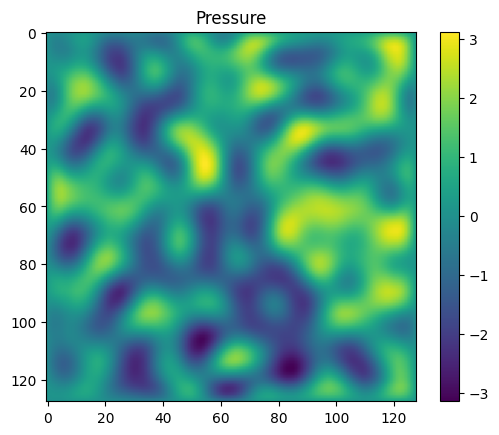

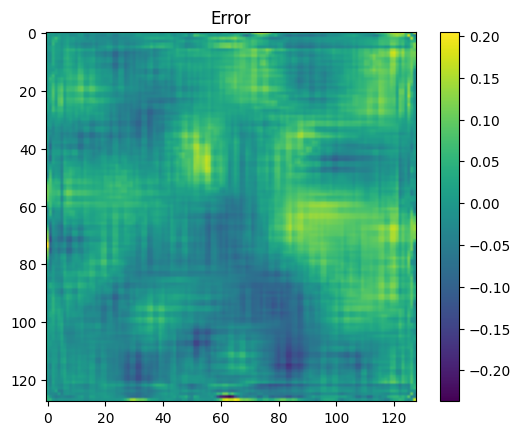

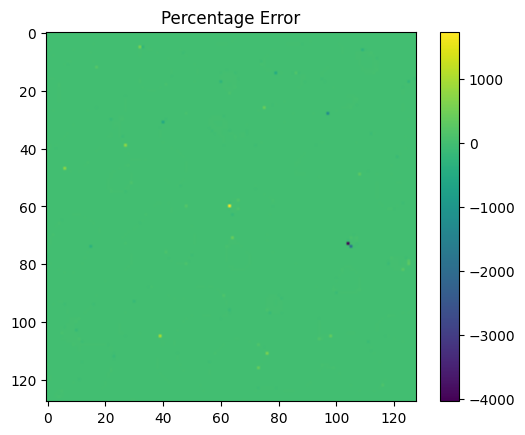

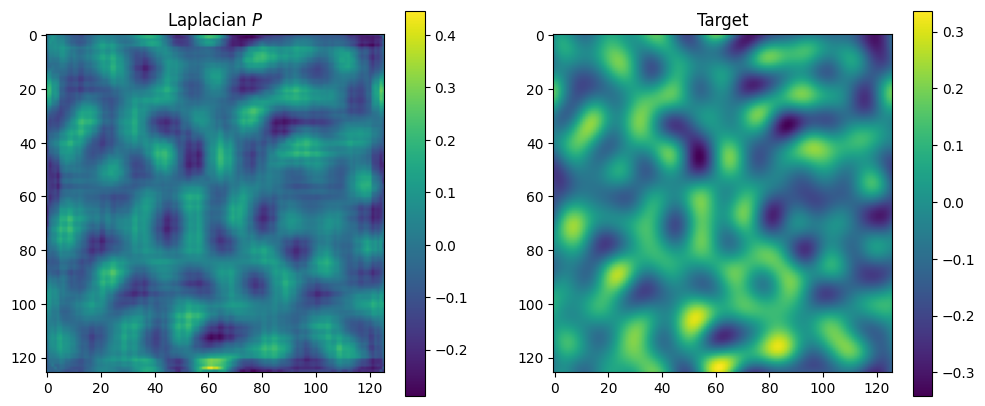

In [15]:
# std is 1.
# The dataset has been trained with std to be 0.2
p_true = tf.random.normal((1,128,128,1))
std = tf.math.reduce_std(p_true)
p_true = p_true / (std*20)

t1 = tf.nn.convolution(p_true, L, padding="SAME")
t1_dev = tf.math.reduce_std(t1)
print(t1_dev)
t1 = tf.random.normal((1,128,128,1)) * (0.2 / t1_dev)   # normalize standard deviation

from myPackageUtils.spatial_filter import spatial_filter
(N_x, N_y) = (128, 128)
random_noise1 = np.random.normal(size=(N_x, N_y))
t1 = spatial_filter(random_noise1, char_len=15).astype(np.double)
t1 = tf.constant(t1.reshape((1,N_x, N_y,1)), dtype=tf.float32)

p_out = model(t1)

lap_p = tf.nn.convolution(p_out, L, padding="SAME")

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(p_out[0,:,:,0])
plt.title("Pressure")
plt.colorbar()
# First figure
plt.figure()
plt.imshow( lap_p[0,:,:,0] - t1[0,:,:,0] ) 
plt.title("Error")
plt.colorbar()

plt.figure()
plt.imshow( tf.divide((lap_p[0,:,:,0] - t1[0,:,:,0]), t1[0,:,:,0]) )
plt.title("Percentage Error")
plt.colorbar()
# Second figure
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow( lap_p[0,1:-1,1:-1,0])
plt.title("Laplacian $P$")
plt.colorbar()
plt.subplot(1,2,2)
plt.title("Target")
plt.imshow( t1[0,1:-1,1:-1,0])
plt.colorbar()
# plt.imshow(t1[0,:,:,0])